In [1]:
# Written by Varun Hiremath
# A starter notebook for the Flame AI challenge
#  - implements a simple 8x nearest interpolation model
#  - provides methods to extract and visualize the LR/HR data with model predicted HR data

In [2]:
import numpy as np                                                                                                                                                                                                                                                                        
import matplotlib.pyplot as plt                                                                                                                                                                                                                                                           
import seaborn as sns                                                                                                                                                                                                                                                                    
import pandas as pd
import os                                                                                                                                                                                                                                                                                         
import tensorflow as tf

In [3]:
input_path = '/kaggle/input/2023-flame-ai-challenge/dataset/'
output_path = '/kaggle/working/'

FILES = {}                                                                                                                                                                                                                                                                                
FILES["train"] = pd.read_csv(input_path+'train.csv').reset_index()                                                                                                                                                                                                                        
FILES["val"]   = pd.read_csv(input_path+'val.csv').reset_index()
FILES["test"]  = pd.read_csv(input_path+'test.csv').reset_index()    

RES_SIZE = {}
RES_SIZE["LR"] = 16
RES_SIZE["HR"] = 128

my_mean = np.array([0.24,28.0, 28.0, 28.0])
my_std = np.array([0.068,48.0, 48.0, 48.0])

In [4]:
# get data in tensor flow format for given resolution and mode (train/val/test)
def get_data_in_tf(res, mode, idx):
    data_path = input_path+"flowfields/%s/%s" % (res, mode)                                                                                                                                                                                                                               
    file_df = FILES[mode]
    file_df.head()
    fid = file_df['id'][idx]
    
    RHO_filename = file_df['rho_filename'][idx]                                                                                                                                                                                                                                           
    UX_filename = file_df['ux_filename'][idx]                                                                                                                                                                                                                                             
    UY_filename = file_df['uy_filename'][idx]                                                                                                                                                                                                                                             
    UZ_filename = file_df['uz_filename'][idx]
    
    size = RES_SIZE[res]
    RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4").reshape(size,size)                                                                                                                                                                                                                     
    UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4").reshape(size,size)                                                                                                                                                                                                                          
    UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4").reshape(size,size)                                                                                                                                                                                                                          
    UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4").reshape(size,size)
   
    X = tf.stack([RHO,UX,UY,UZ],axis=2)
    return fid,X

# predict solution using given model for one input in specified mode (train/val/test)
def predict(model, mode, idx):
    fid,X = get_data_in_tf("LR", mode, idx)
    X = tf.expand_dims(X,0)
    y_pred = model.predict(X,verbose=0)
    return fid,y_pred

In [5]:
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.UpSampling2D(size=(8,8), interpolation='lanczos5', input_shape=(16,16,4)))
    return model

model = create_model()

In [6]:
def plot_data(model, mode, idx):    
    fid,x0_real = get_data_in_tf("LR", mode, idx)
    if (mode != "test"): #no HR data available for test mode
        fid,y0_real = get_data_in_tf("HR", mode, idx)
    fid,y0_pred = predict(model, mode, idx)
    
    rows = 2 if (mode == "test") else 3
    fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))
    fig.suptitle("Comparison for %s data at id = %d with file id = %d" %(mode, idx, fid), fontsize=16)
    
    VARS = ["RHO", "UX", "UY", "UZ"]
    for i in range(4):
        axs[0,i].imshow(x0_real[:,:,i], cmap='jet')
        axs[0,i].set_title('LR Data 16x16: %s' % VARS[i])
        
        axs[1,i].imshow(y0_pred[0][:,:,i], cmap='jet')
        axs[1,i].set_title('Prediction 128x128: %s' % VARS[i])
        
        if (mode != "test"):
            axs[2,i].imshow(y0_real[:,:,i], cmap='jet')
            axs[2,i].set_title('HR Data 128x128: %s' % VARS[i])
        

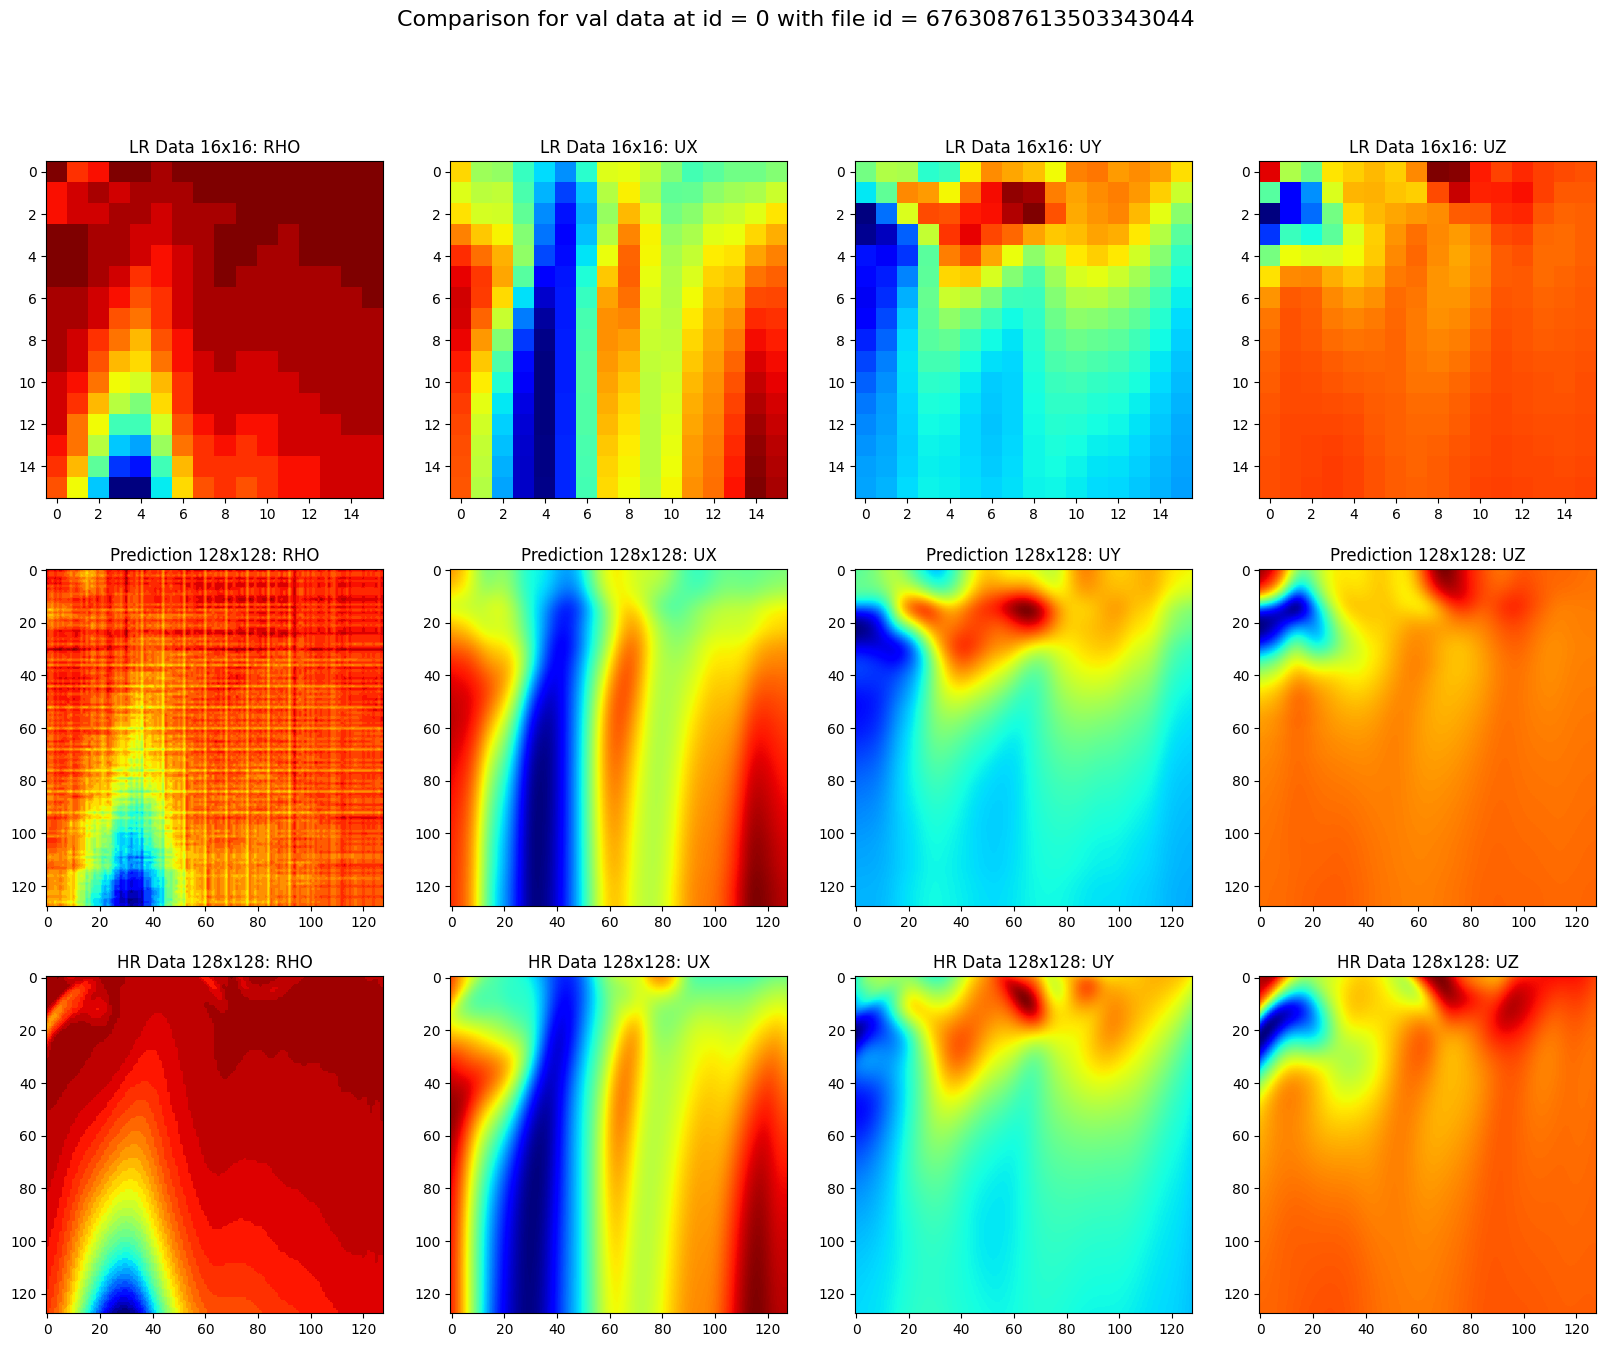

In [7]:
plot_data(model, "val", 0)

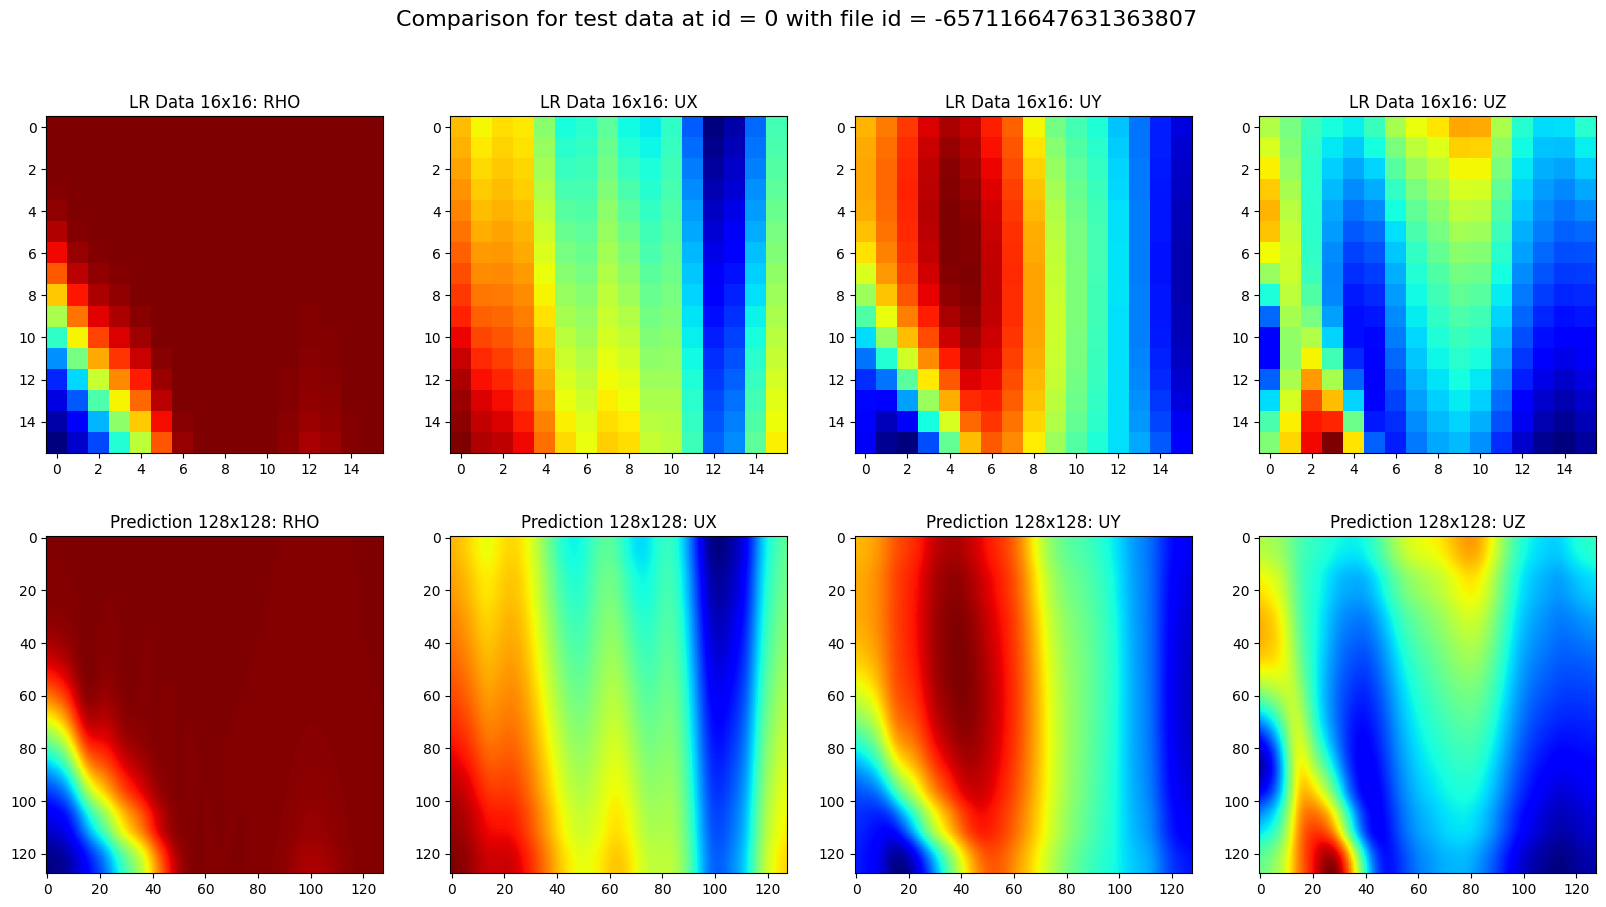

In [8]:
plot_data(model, "test", 0)

In [9]:
# generates solutions using given model for the specified mode of data
def generate_solutions(model, mode):
    y_preds = {}
    ids = []
    for idx in range(len(FILES[mode])):
        fid,y_pred = predict(model, mode, idx) 
        ids.append(fid)
        
        data = (np.array(y_pred) - my_mean)/my_std #this normalizes density and velocity to be in the same range        
        y_preds[fid] = np.array(data).flatten(order='C').astype(np.float32)
        
    df = pd.DataFrame.from_dict(y_preds,orient='index')
    df['id'] = ids
    #move id to first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    #reset index
    df = df.reset_index(drop=True)

    return df

In [10]:
# generate solutions for the test data
df = generate_solutions(model, "test")
df.head()

,id,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,-657116647631363807,0.975979,0.951884,-0.542434,-0.573417,0.975985,0.948571,-0.542157,-0.573532,0.975992,...,-0.605407,-0.600609,0.974874,0.915999,-0.605809,-0.600503,0.974831,0.921482,-0.606169,-0.600421
1,7483162365939134796,0.976179,0.740572,-0.581017,-0.585207,0.976178,0.755280,-0.581150,-0.585193,0.976178,...,-0.390815,-0.595121,0.976158,0.301238,-0.383168,-0.595270,0.976159,0.305486,-0.376170,-0.595332
2,-6212758420087317096,0.976182,0.665970,-0.585022,-0.580913,0.976181,0.665986,-0.585015,-0.580926,0.976182,...,-0.574217,-0.574941,0.976181,0.858322,-0.574141,-0.574915,0.976182,0.854849,-0.574068,-0.574893
3,-1825935182480952214,-0.891691,1.293365,-0.457427,-1.100051,-0.891680,1.282909,-0.438982,-1.084717,-0.891668,...,-0.890568,-1.332729,-0.901690,1.809902,-0.916662,-1.348694,-0.901614,1.818385,-0.939408,-1.362310
4,-1859240836295259171,2.519542,-0.545422,-0.557016,-0.582521,2.519511,-0.545332,-0.557005,-0.582547,2.519478,...,-0.367054,-0.769400,0.934416,-0.353573,-0.365889,-0.770048,0.919411,-0.353022,-0.364846,-0.770664


In [11]:
# generate the output file for submission
df.to_csv(output_path+'lanczos5_interpolation.csv',index=False)